##### STEP 1: 数据加载以及添加column names

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
adult_data_path = "./data/adult.data"
adult_test_path = "./data/adult.test"

columns = ["age", "workclass", "fnlwgt", "education", "education_num", "marital_status",
           "occupation", "relationship", "race", "sex", "capital_gain", "capital_loss",
           "hours_per_week", "native_country", "income"]

adult_df = pd.read_csv(adult_data_path, names=columns)
adult_test_df = pd.read_csv(adult_test_path, names=columns)

adult_df.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


##### STEP 2: 数据清洗

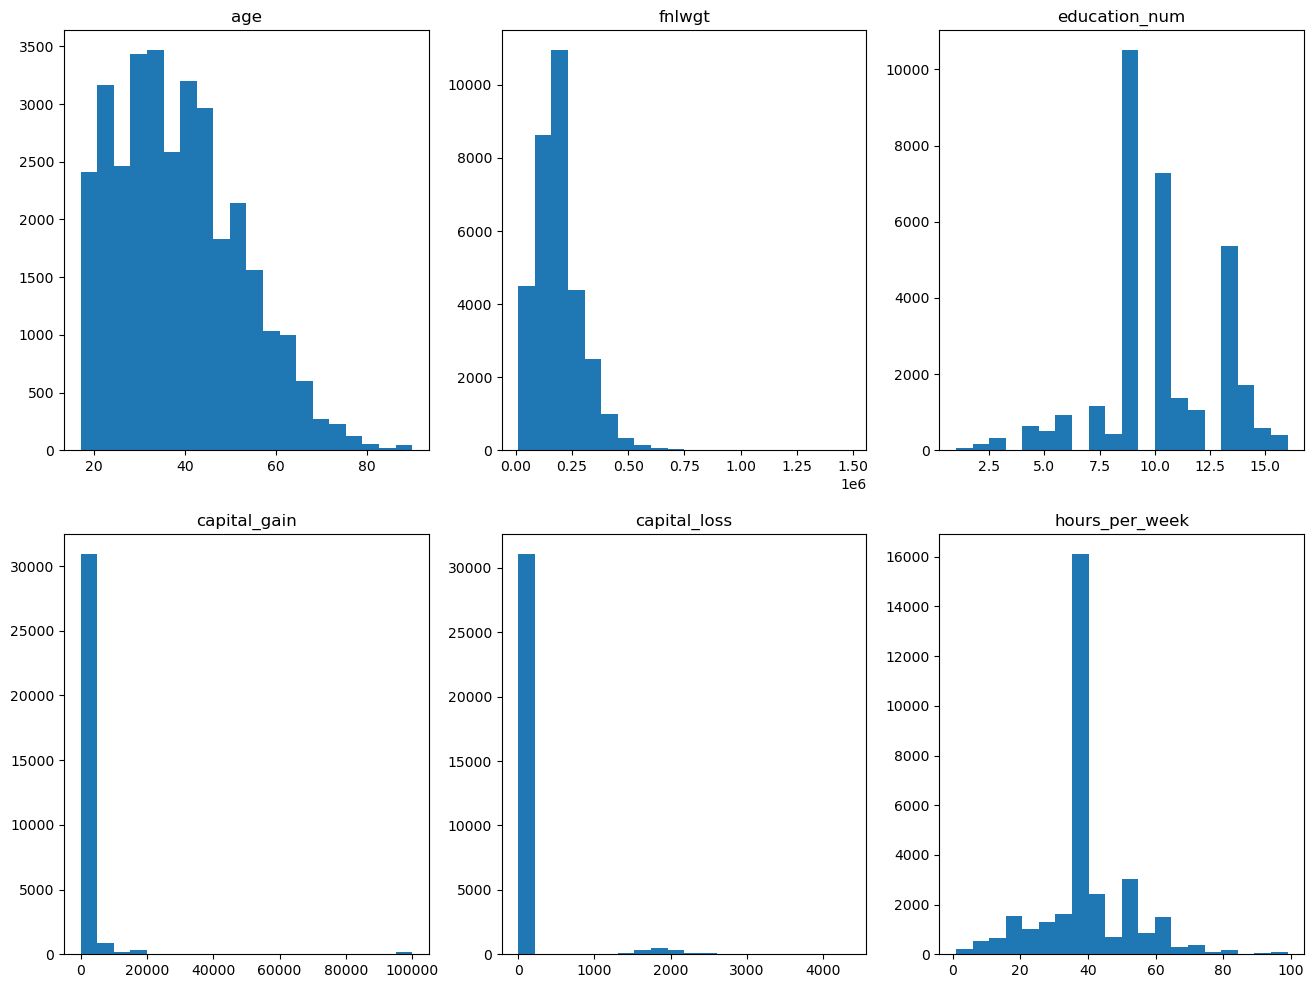

In [3]:
# 针对数值类型的columns，检查其数据分布情况
numerical_columns = ["age", "fnlwgt", "education_num", "capital_gain", "capital_loss", "hours_per_week"]

# 绘制各个字段的数据分布图
fig = plt.figure(figsize=(16, 12))
for i, col in enumerate(numerical_columns):
    ax = fig.add_subplot(2, 3, i + 1)
    ax.hist(adult_df[col], bins=20)
    ax.set_title(col)
    
plt.show()

##### 基于上面的数据分布图，可以得出如下分析结论
- capital_gain 和 capital_loss 两个字段的数据过于稀疏，99%以上数据为0，很大概率存在数据缺失，使用这两个数据来分析与收入的相关性的价值可能不高。
- 其他几个字段的数据分布相对正常，没有发现明显的异常数据。

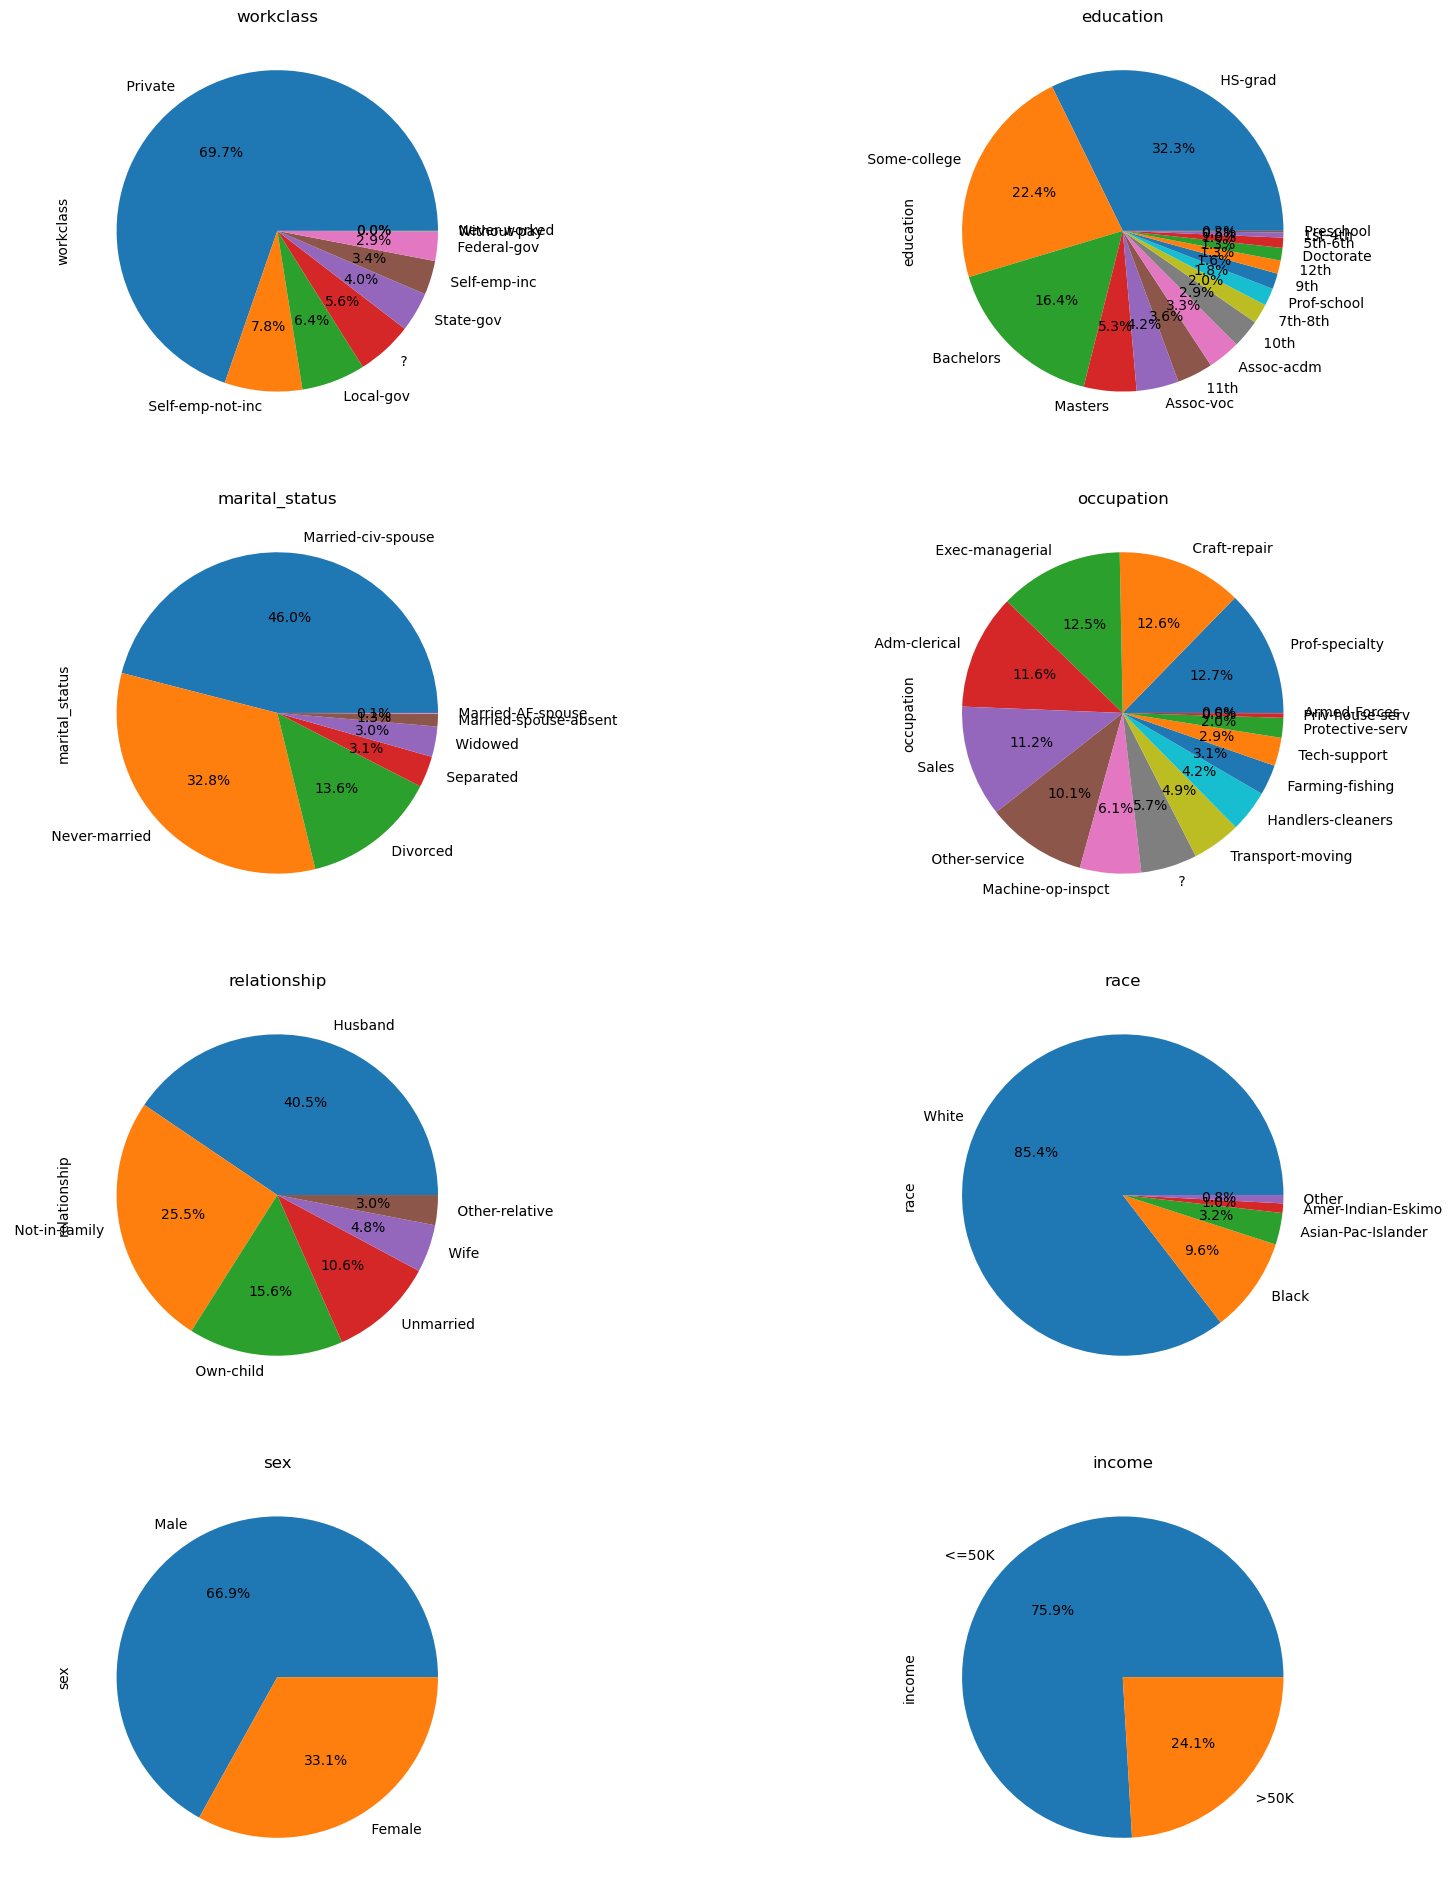

In [4]:
# 针对非数值字段，检查其数据分布情况（native_country字段数量太大，不适合展示，这里不做可视化）
category_columns = ["workclass", "education", "marital_status", "occupation", "relationship",
                    "race", "sex", "income"]

# 绘制各个字段的数据分布图（采用饼图）
fig = plt.figure(figsize=(20, 24))

for i, col in enumerate(category_columns):
    # 增大每个子图的大小
    ax = fig.add_subplot(4, 2, i + 1)
    adult_df[col].value_counts().plot(kind="pie", ax=ax, autopct="%1.1f%%")
    ax.set_title(col)
   
plt.show()

##### 基于上面的数据分布图，可以得出以下结论
- workclass 以及 occupation 两个字段分别存在 5.6% 和 5.7% 的数据缺失，需要对这部分数据进行过滤。
- 其他字段的数据分布正常。

In [5]:
# 进行数据清洗，过滤掉为取值为 ? 的数据
# 第一步需要先去掉所有value值中空格
adult_df = adult_df.apply(lambda x: x.str.strip() if x.dtype == "object" else x)
adult_test_df = adult_test_df.apply(lambda x: x.str.strip() if x.dtype == "object" else x)

# 统计过滤前的数据量
print("adult_df过滤前的数据量：", adult_df.shape[0])
print("adult_test_df过滤前的数据量：", adult_test_df.shape[0])

# 将 ? 替换为 np.nan
adult_df = adult_df.replace("?", np.nan)
adult_test_df = adult_test_df.replace("?", np.nan)

# 过滤掉为 np.nan 的数据
adult_df_filter = adult_df.dropna()
adult_test_df_filter = adult_test_df.dropna()

# 统计过滤后的数据量
print("adult_df过滤后的数据量：", adult_df_filter.shape[0])
print("adult_test_df过滤后的数据量：", adult_test_df_filter.shape[0])

# 统计异常数据占比（按照百分比输出）
print("adult_df异常数据占比：", (1 - adult_df_filter.shape[0] / adult_df.shape[0]) * 100, "%")
print("adult_test_df异常数据占比：", (1 - adult_test_df_filter.shape[0] / adult_test_df.shape[0]) * 100, "%")

adult_df过滤前的数据量： 32561
adult_test_df过滤前的数据量： 16282
adult_df过滤后的数据量： 30162
adult_test_df过滤后的数据量： 15060
adult_df异常数据占比： 7.367709836921465 %
adult_test_df异常数据占比： 7.505220488883435 %


- 对 age, education_num, hours_per_week 三个字段的数值进行分段处理，方便后续计算与收入的相关性

In [6]:
# 首先对 age 字段进行分段处理
# 0-18岁为少年，18-30岁为青年，30-50岁为中年，50-70岁为老年，70岁以上为老老年
adult_df_filter['age_category'] = pd.cut(adult_df_filter["age"], bins=[0, 18, 30, 50, 70, 100], labels=["child", "youth", "middle", "old", "very_old"])

# 对education_num字段进行分段处理
# n取值为4
# 划分为n个阶段，取最小值和最大值，然后均分为n份
education_num_min = adult_df_filter["education_num"].min()
education_num_max = adult_df_filter["education_num"].max()
edu_num_bins = np.linspace(education_num_min, education_num_max, 4)
adult_df_filter['education_num_category'] = pd.cut(adult_df_filter["education_num"], bins=edu_num_bins, labels=["low", "middle", "high"])

# 对hours_per_week字段进行分段处理
# 划分为n个阶段，取最小值和最大值，然后均分为n份
hours_per_week_min = adult_df_filter["hours_per_week"].min()
hours_per_week_max = adult_df_filter["hours_per_week"].max()
hours_per_week_bins = np.linspace(hours_per_week_min, hours_per_week_max, 4)
adult_df_filter['hours_per_week_category'] = pd.cut(adult_df_filter["hours_per_week"], bins=hours_per_week_bins, labels=["low", "middle", "high"])

adult_df_filter.head()

/var/folders/_8/x1k4hht97fj9ff8y1t982cdc0000gn/T/ipykernel_4810/1487564150.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adult_df_filter['age_category'] = pd.cut(adult_df_filter["age"], bins=[0, 18, 30, 50, 70, 100], labels=["child", "youth", "middle", "old", "very_old"])
/var/folders/_8/x1k4hht97fj9ff8y1t982cdc0000gn/T/ipykernel_4810/1487564150.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adult_df_filter['education_num_category'] = pd.cut(adult_df_filter["education_num"], bins=edu_num_bins, l

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income,age_category,education_num_category,hours_per_week_category
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K,middle,high,middle
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K,middle,high,low
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K,middle,middle,middle
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K,old,middle,middle
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K,youth,high,middle


##### STEP 3: 数据可视化

##### 参考思路

多变量可视化的常见方法包括：

- 散点图矩阵（Scatterplot Matrix）：将数据集中的多个变量两两组合，分别绘制散点图，方便观察不同变量之间的相关性。

- 平行坐标图（Parallel Coordinates Plot）：将数据集中的每个实例（行）抽象为一条线段，每个变量对应线段的一个维度，方便比较不同实例之间的差异。

- 热力图（Heatmap）：将数据集中的多个变量转换成颜色，并在图像上绘制，以展示不同变量之间的关系。

- 三维散点图（3D Scatterplot）：将数据集中的三个变量绘制在三维坐标系中，以观察它们之间的三维关系。

- 树状图（Tree Map）：将数据集中的多个变量组织成树形结构，并用矩形面积来表示各节点的数据值，以便比较不同节点之间的大小关系。

- 聚类散点图（Clustered Scatterplot）：将数据集中的多个变量进行聚类，并将聚类结果绘制为散点图，方便观察不同类别之间的差异。

- 阶梯图（Step Chart）：将时间序列数据或排名数据按顺序绘制，方便观察变量的时序变化或排名变化趋势。

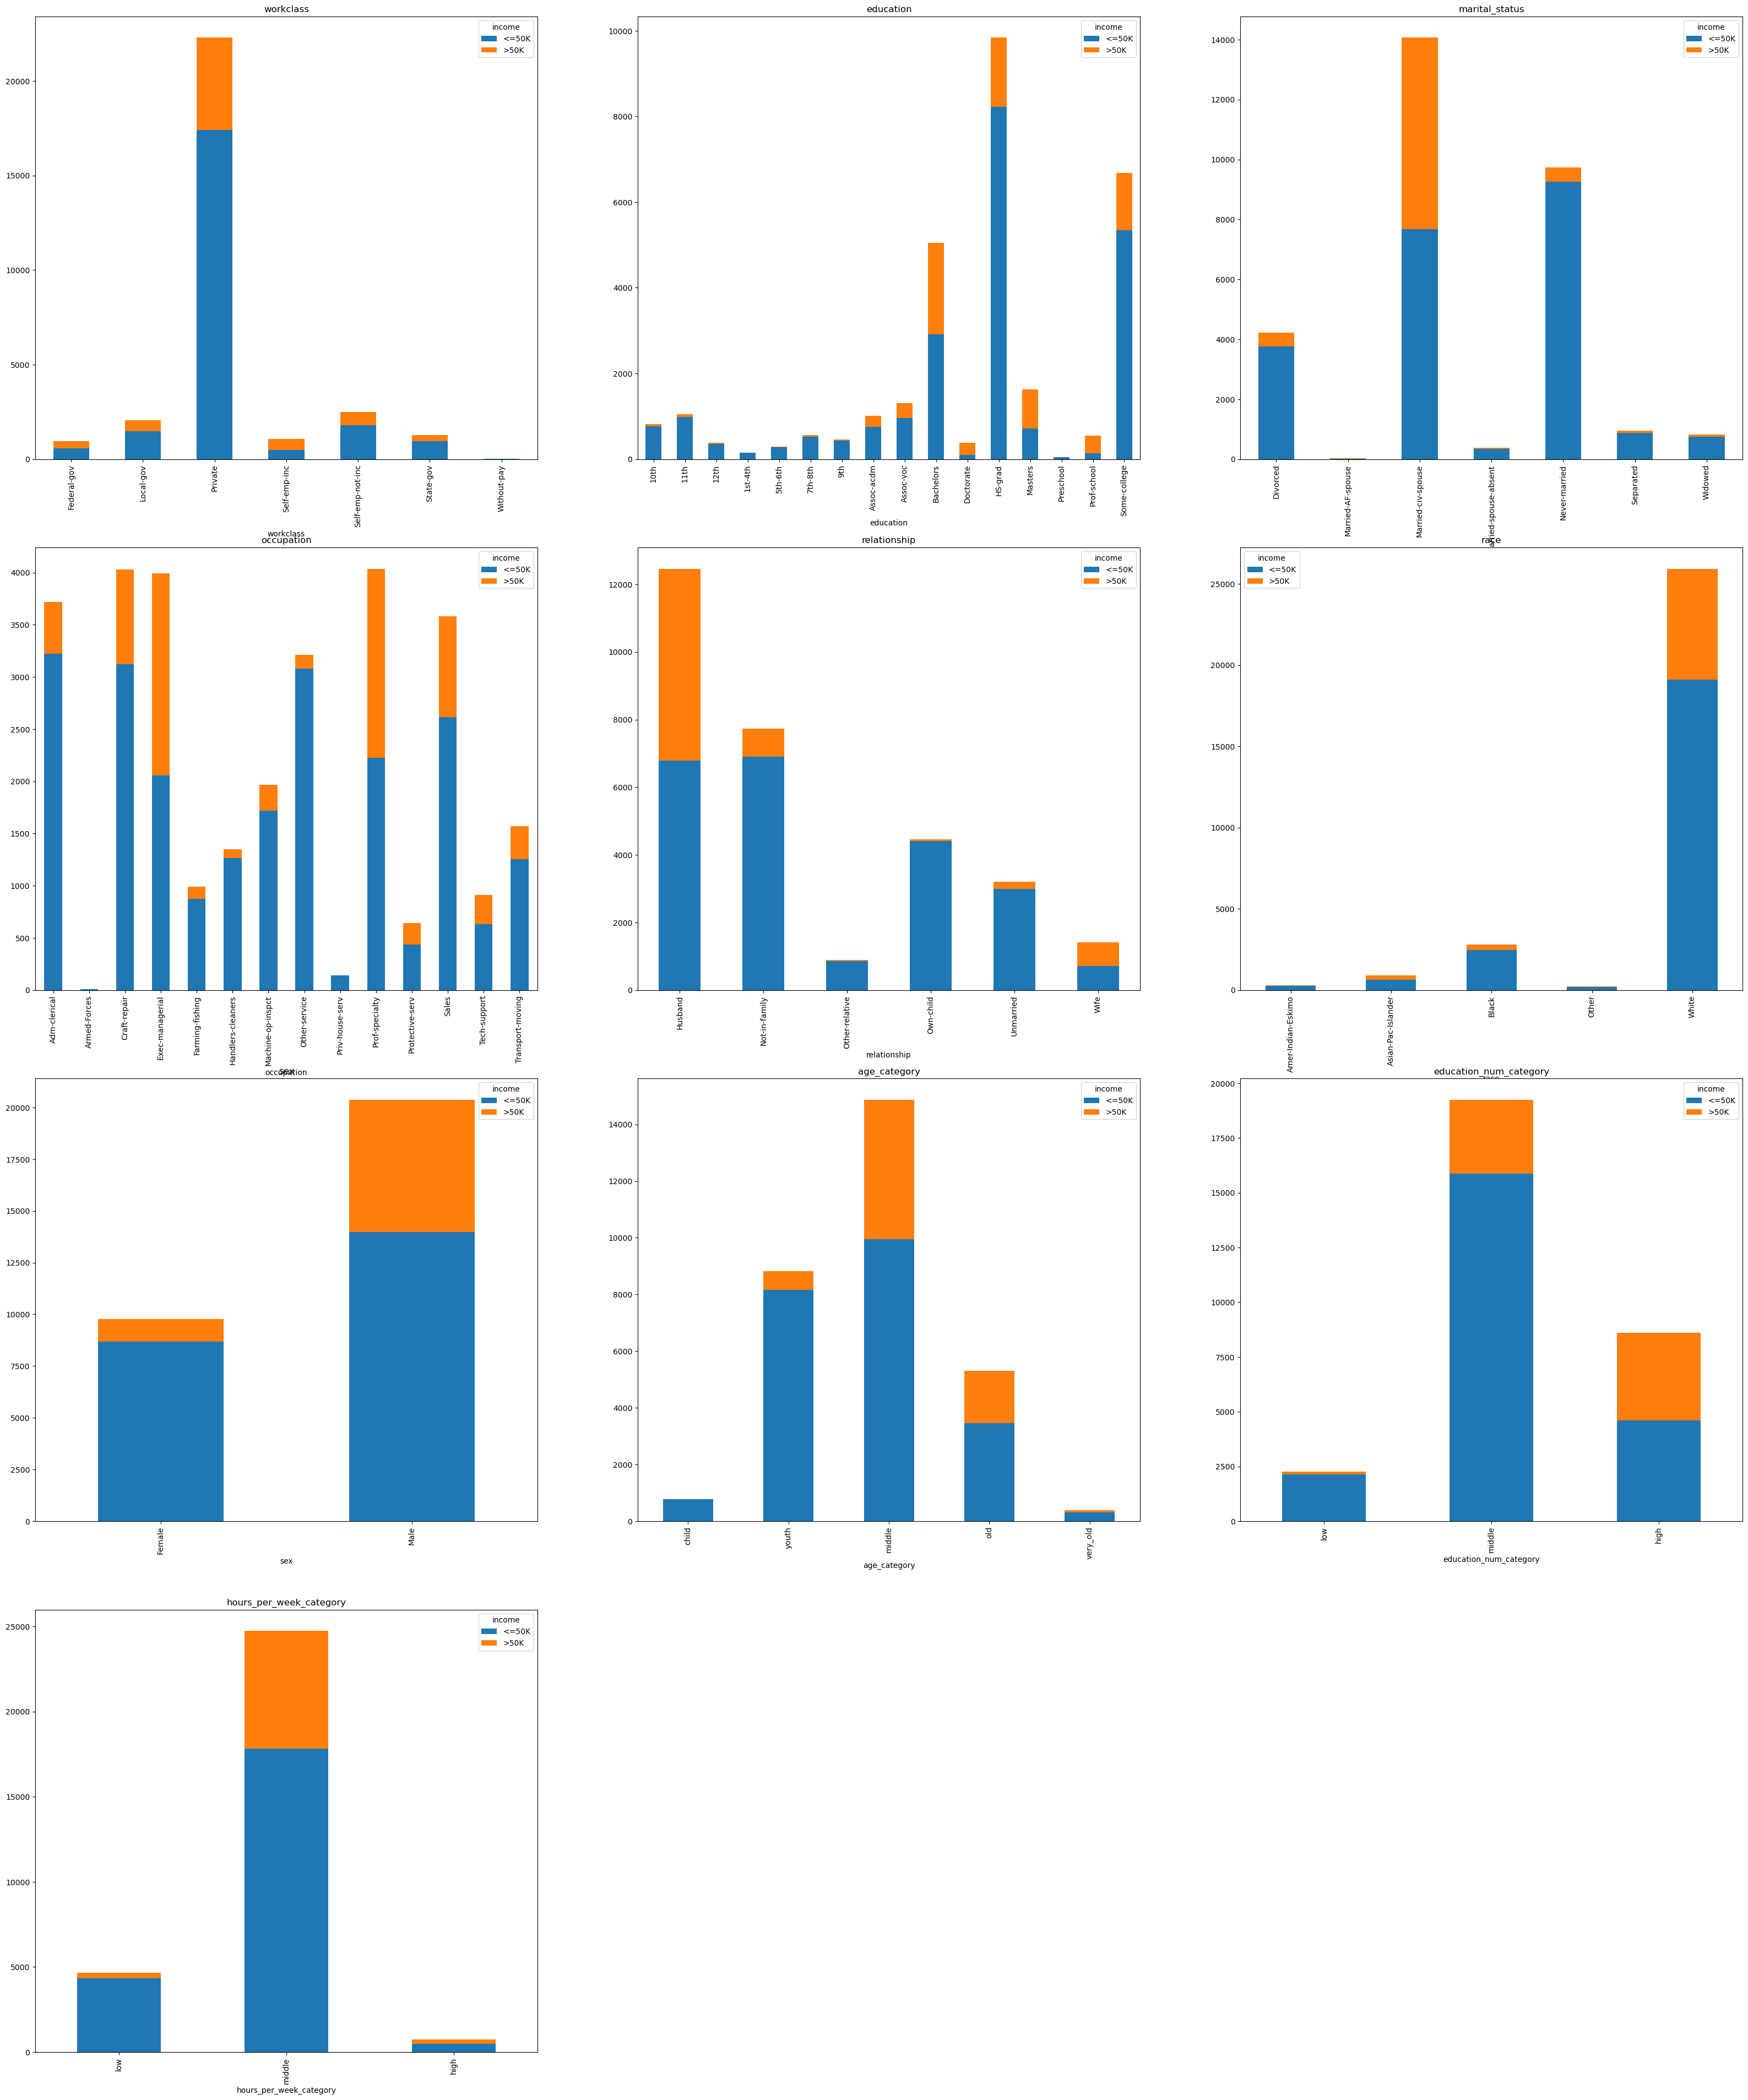

In [7]:
# 首先分析每个字段的不同取值下收入的分布情况，采用柱状图进行可视化
candidate_columns = ["workclass", "education", "marital_status",
                     "occupation", "relationship", "race", "sex",
                     "age_category", "education_num_category", "hours_per_week_category"]

fig = plt.figure(figsize=(40, 48))

for i, col in enumerate(candidate_columns):
    ax = fig.add_subplot(4, 3, i + 1)
    adult_df_filter.groupby([col, "income"]).size().unstack().plot(kind="bar", stacked=True, ax=ax)
    ax.set_title(col)

plt.show()

##### 根据上面的可视化，可以得到一些分析结论：
- 对于收入比较有区分度的变量主要有以下几个： relationship, age_catrgory, education, race, occupation （例如：relationship=Husband的高收入占比明显超出平均值，other-relatively 和 own-child 的则低收入占比显著升高； age 较低或较高的人群低收入占比更高 等。）
- hours_per_week_category 以及 education_num_category 目前分为3段，可以尝试扩大分段数量。
- 进行多变量分析可以优先从 relationship, age_catrgory, education, race, occupation 等变量中选择符合逻辑的组合来进行对比。

##### 可视化的参考选择

- 针对数值类型的几个字段，如 "age", "hours_per_week", "education_num", 采用散点图来观察其与收入关系； 预期的可视化效果：高收入人群的点应该相对集中在青壮年、每周工作时长较长且受教育年限较多的区间；同时低收入人群的点相对集中在年龄较小或较大，工作时长短、且受教育年限短的区间。
- 针对离散类型的字段，如 "sex","relationship", "race", 可以采用热力图，在不同的变量取值组合下，高收入人群的比例越高，图像的颜色越深，反之则越浅。
- 利用聚类散点图来同时考虑不同类型的变量，可以包括（relationship, age_catrgory, education, race, occupation）等相对区分度较高的变量；预期的可视化效果为： 高收入人群会相对集中于一个或多个类簇，低收入人群也会相对集中于一个或多个类簇。